# Score Distribution Example
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Dec 20, 2021

In [39]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [30]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [32]:
lkupclientid = 7 # canucks
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrCanucks].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(32915, 54)

### We should specify the features used in our model:

In [33]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (23643, 9)
Unseen Data For Predictions: (4172, 9)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [34]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's compare all models to evaluate performance. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time.

In [36]:
model_matrix = compare_models(
    fold=10,
    include=["et","lr","lightgbm","xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7932,0.8685,0.8154,0.7912,0.8030,0.5856,0.5860,0.4500
lightgbm,Light Gradient Boosting Machine,0.7788,0.8581,0.7926,0.7824,0.7874,0.5569,0.5571,1.5190
et,Extra Trees Classifier,0.7066,0.7700,0.7230,0.7134,0.7181,0.4122,0.4122,0.4650
lr,Logistic Regression,0.6196,0.6882,0.7164,0.6164,0.6603,0.2336,0.2392,0.0240


In [40]:
et = create_model('et')
lightgbm = create_model('lightgbm')
lr = create_model('lr')
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8075,0.8799,0.8258,0.8064,0.8160,0.6142,0.6143
1,0.7876,0.8612,0.8123,0.7844,0.7981,0.5741,0.5745
2,0.7995,0.8798,0.8200,0.7978,0.8087,0.5982,0.5984
3,0.7801,0.8617,0.7834,0.7895,0.7865,0.5598,0.5598
4,0.7925,0.8663,0.8123,0.7917,0.8019,0.5842,0.5844
5,0.7900,0.8677,0.8354,0.7757,0.8044,0.5785,0.5803
6,0.7959,0.8694,0.8179,0.7935,0.8055,0.5909,0.5912
7,0.8054,0.8732,0.8256,0.8032,0.8143,0.6099,0.6102
8,0.8029,0.8763,0.8191,0.8036,0.8112,0.6050,0.6052
9,0.7710,0.8492,0.8017,0.7663,0.7836,0.5408,0.5414


### Let's load in our 2021 season data and get retention scores using the model:

In [37]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5100, 9)

In [ ]:
et_predictions = predict_model(et, data=df_inference, raw_score=True)
lr_predictions = predict_model(lr, data=df_inference, raw_score=True)
lightgbm_predictions = predict_model(lightgbm, data=df_inference, raw_score=True)
xgboost_predictions = predict_model(xgboost, data=df_inference, raw_score=True)

et distribution:


array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

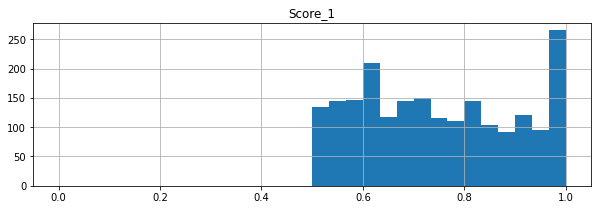

In [14]:
print("et distribution:")
et_predictions[et_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,3), range=[0,1])

In [21]:
et_predictions["Score_1"].value_counts(bins=[0.50, 0.60, 0.70, 0.80, 0.90, 1])

(0.499, 0.6]    511
(0.6, 0.7]      469
(0.9, 1.0]      457
(0.7, 0.8]      376
(0.8, 0.9]      324
Name: Score_1, dtype: int64

lightgbm distribution:


array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

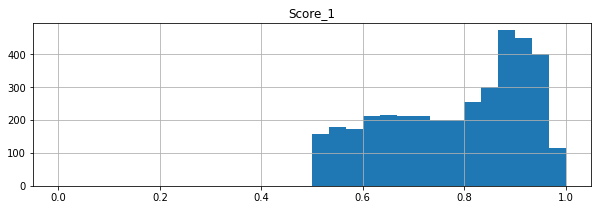

In [160]:
print("lightgbm distribution:")
lightgbm_predictions[lightgbm_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,3), range=[0,1])

In [20]:
lightgbm_predictions["Score_1"].value_counts(bins=[0.50, 0.60, 0.70, 0.80, 0.90, 1])

(0.499, 0.6]    687
(0.7, 0.8]      533
(0.6, 0.7]      507
(0.8, 0.9]      196
(0.9, 1.0]      162
Name: Score_1, dtype: int64

logistic regression:


array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

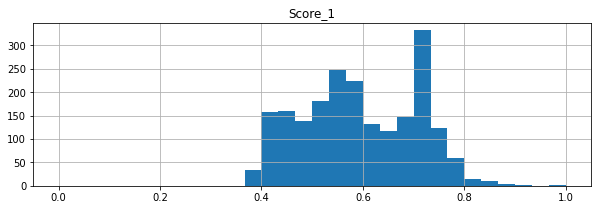

In [15]:
print("logistic regression:")
lr_predictions[lightgbm_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,3), range=[0,1])

In [22]:
lr_predictions["Score_1"].value_counts(bins=[0.50, 0.60, 0.70, 0.80, 0.90, 1])

(0.499, 0.6]    1320
(0.7, 0.8]       630
(0.6, 0.7]       619
(0.8, 0.9]        33
(0.9, 1.0]         9
Name: Score_1, dtype: int64

xgboost distribution:


array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

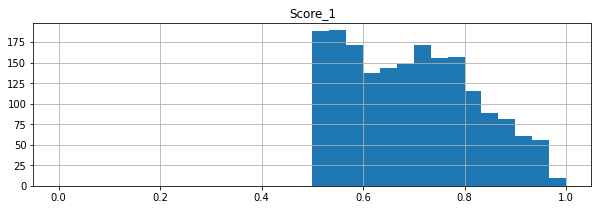

In [16]:
print("xgboost distribution:")
xgboost_predictions[xgboost_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,3), range=[0,1])

xgboost distribution:


array([[<AxesSubplot:title={'center':'Score_0'}>]], dtype=object)

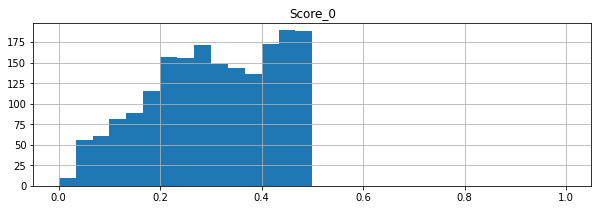

In [25]:
print("xgboost distribution:")
xgboost_predictions[xgboost_predictions["Label"]==1][["Score_0"]].hist(bins=30, figsize=(10,3), range=[0,1])

In [24]:
xgboost_predictions["Score_1"].value_counts(bins=[0.50, 0.60, 0.70, 0.80, 0.90, 1])

(0.499, 0.6]    548
(0.7, 0.8]      483
(0.6, 0.7]      428
(0.8, 0.9]      285
(0.9, 1.0]      127
Name: Score_1, dtype: int64